In [1]:
# Parameters
kms_key = "arn:aws:kms:us-west-2:000000000000:1234abcd-12ab-34cd-56ef-1234567890ab"


# MNIST Handwritten Digits Classification Experiment

This demo shows how you can use SageMaker Experiment Management Python SDK to organize, track, compare, and evaluate your machine learning (ML) model training experiments.

You can track artifacts for experiments, including data sets, algorithms, hyper-parameters, and metrics. Experiments executed on SageMaker such as SageMaker Autopilot jobs and training jobs will be automatically tracked. You can also track artifacts for additional steps within an ML workflow that come before/after model training e.g. data pre-processing or post-training model evaluation.

The APIs also let you search and browse your current and past experiments, compare experiments, and identify best performing models.

Now we will demonstrate these capabilities through an MNIST handwritten digits classification example. The experiment will be organized as follow:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyper parameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of Python SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We will also see an example of tracing the complete linage of a model version i.e. the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Make sure you selected `Python 3 (Data Science)` kernel.

### Install Python SDKs

In [2]:
import sys

In [3]:
!{sys.executable} -m pip install sagemaker-experiments==0.1.24

  Attempting uninstall: sagemaker-experiments
    Found existing installation: sagemaker-experiments 0.1.31
    Uninstalling sagemaker-experiments-0.1.31:


      Successfully uninstalled sagemaker-experiments-0.1.31


### Install PyTroch

In [4]:
# pytorch version needs to be the same in both the notebook instance and the training job container
# https://github.com/pytorch/pytorch/issues/25214
!{sys.executable} -m pip install torch==1.1.0
!{sys.executable} -m pip install torchvision==0.3.0
!{sys.executable} -m pip install pillow==6.2.2
!{sys.executable} -m pip install --upgrade sagemaker

     |                                | 163 kB 2.3 MB/s eta 0:04:54

     |                                | 1.8 MB 2.3 MB/s eta 0:04:54

     |▏                               | 3.7 MB 2.3 MB/s eta 0:04:53

     |▎                               | 5.3 MB 2.3 MB/s eta 0:04:52

     |▍                               | 7.3 MB 2.3 MB/s eta 0:04:51

     |▍                               | 9.4 MB 2.3 MB/s eta 0:04:50

     |▌                               | 11.5 MB 2.3 MB/s eta 0:04:49

     |▋                               | 12.0 MB 2.3 MB/s eta 0:04:49

     |▋                               | 13.3 MB 2.3 MB/s eta 0:04:49

     |▊                               | 15.0 MB 2.3 MB/s eta 0:04:48

     |▉                               | 16.7 MB 2.3 MB/s eta 0:04:47

     |█                               | 21.3 MB 1.5 MB/s eta 0:07:23

     |█▏                              | 23.7 MB 1.5 MB/s eta 0:07:22

     |█▏                              | 25.6 MB 1.5 MB/s eta 0:07:20

     |█▍                              | 28.4 MB 1.5 MB/s eta 0:07:18

     |█▍                              | 30.2 MB 1.5 MB/s eta 0:07:17

     |█▌                              | 32.0 MB 1.5 MB/s eta 0:07:16

     |█▋                              | 33.8 MB 1.5 MB/s eta 0:07:15

     |█▊                              | 36.2 MB 1.5 MB/s eta 0:07:13

     |█▊                              | 37.5 MB 1.5 MB/s eta 0:07:12

     |█▉                              | 39.4 MB 1.5 MB/s eta 0:07:11

     |██                              | 41.3 MB 1.7 MB/s eta 0:06:23

     |██                              | 43.3 MB 1.7 MB/s eta 0:06:22

     |██                              | 44.4 MB 1.7 MB/s eta 0:06:21

     |██▏                             | 46.6 MB 1.7 MB/s eta 0:06:20

     |██▎                             | 47.2 MB 1.7 MB/s eta 0:06:20

     |██▎                             | 48.5 MB 1.7 MB/s eta 0:06:19

     |██▍                             | 49.8 MB 1.7 MB/s eta 0:06:18

     |██▍                             | 51.1 MB 1.7 MB/s eta 0:06:17

     |██▌                             | 52.9 MB 1.7 MB/s eta 0:06:16

     |██▋                             | 55.4 MB 1.7 MB/s eta 0:06:15

     |██▊                             | 57.0 MB 1.7 MB/s eta 0:06:14

     |██▉                             | 58.9 MB 1.3 MB/s eta 0:07:44

     |██▉                             | 60.4 MB 1.3 MB/s eta 0:07:43

     |███                             | 62.4 MB 1.3 MB/s eta 0:07:42

     |███                             | 65.6 MB 1.3 MB/s eta 0:07:39

     |███▏                            | 66.7 MB 1.3 MB/s eta 0:07:39

     |███▎                            | 68.8 MB 1.3 MB/s eta 0:07:37

     |███▍                            | 70.8 MB 1.3 MB/s eta 0:07:36

     |███▌                            | 73.1 MB 1.3 MB/s eta 0:07:34

     |███▌                            | 74.8 MB 1.3 MB/s eta 0:07:32

     |███▋                            | 76.7 MB 1.3 MB/s eta 0:07:43

     |███▊                            | 78.2 MB 1.3 MB/s eta 0:07:42

     |███▊                            | 78.6 MB 1.3 MB/s eta 0:07:42

     |███▉                            | 80.0 MB 1.3 MB/s eta 0:07:41

     |███▉                            | 81.3 MB 1.3 MB/s eta 0:07:40

     |████                            | 83.3 MB 1.3 MB/s eta 0:07:38

     |████                            | 83.8 MB 1.3 MB/s eta 0:07:38

     |████                            | 84.8 MB 1.3 MB/s eta 0:07:37

     |████▏                           | 87.0 MB 1.3 MB/s eta 0:07:35

     |████▏                     

     |████▎                           | 90.5 MB 1.3 MB/s eta 0:07:33

     |████▍                           | 91.9 MB 1.3 MB/s eta 0:07:32

     |████▍                           | 93.9 MB 1.3 MB/s eta 0:07:35

     |████▌       

     |████▋                           | 97.0 MB 1.3 MB/s eta 0:07:33

     |████▊                           | 99.3 MB 1.3 MB/s eta 0:07:31

     |████▉                           | 101.1 MB 1.3 MB/s eta 0:07:30

     |████▉                           | 103.0 MB 1.3 MB/s eta 0:07:28

     |█████                           | 104.6 MB 1.3 MB/s eta 0:07:27

     |█████                           | 106.5 MB 1.3 MB/s eta 0:07:26

     |█████                           | 108.1 MB 1.3 MB/s eta 0:07:24

     |█████▏                          | 109.9 MB 1.3 MB/s eta 0:07:23

     |█████▎                          | 111.6 MB 1.5 MB/s eta 0:06:23

     |█████▍                          | 112.9 MB 1.5 MB/s eta 0:06:22

     |█████▍                          | 114.4 MB 1.5 MB/s eta 0:06:21

     |█████▌                          | 116.2 MB 1.5 MB/s eta 0:06:20

     |█████▋                          | 118.3 MB 1.5 MB/s eta 0:06:18

     |█████▊                          | 120.0 MB 1.5 MB/s eta 0:06:17

     |█████▊                          | 121.7 MB 1.5 MB/s eta 0:06:16

     |█████▉                          | 123.5 MB 1.5 MB/s eta 0:06:15

     |██████                          | 125.3 MB 1.5 MB/s eta 0:06:14

     |██████                          | 126.9 MB 1.5 MB/s eta 0:06:13

     |██████                 

     |██████                          | 128.6 MB 1.3 MB/s eta 0:07:05

     |██████▏         

     |██████▎                         | 132.2 MB 1.3 MB/s eta 0:07:02

     |██████▎                         | 133.4 MB 1.3 MB/s eta 0:07:0

     |██████▍                         | 135.9 MB 1.3 MB/s eta 0:06:59

     |██████▌                         | 137.3 MB 1.3 MB/s eta 0:06:58

     |██████▋                         | 139.3 MB 1.3 MB/s eta 0:06:56

     |██████▋                         | 140.8 MB 1.3 MB/s eta 0:06:55

     |██████▊                         | 142.0 MB 1.3 MB/s eta 0:06:54

     |██████▉                         | 144.0 MB 1.3 MB/s eta 0:06:53

     |██████▉                         | 145.5 MB 1.5 MB/s eta 0:06:01

     |███████                         | 147.3 MB 1.5 MB/s eta 0:06:00

     |███████                         | 149.0 MB 1.5 MB/s eta 0:05:59

     |███████▏                        | 150.8 MB 1.5 MB/s eta 0:05:58

     |███████▏                        | 152.3 MB 1.5 MB/s eta 0:05:57

     |███████▎                        | 153.8 MB 1.5 MB/s eta 0:05:56

     |███████▍                        | 155.8 MB 1.5 MB/s eta 0:05:54

     |███████▍                        | 156.9 MB 1.5 MB/s eta 0:05:54

     |███████▋                        | 160.5 MB 1.5 MB/s eta 0:05:51

     |███████▊                        | 162.4 MB 1.3 MB/s eta 0:06:42

     |███████▊                        | 163.9 MB 1.3 MB/s eta 0:06:41

     |███████▉                        | 165.2 MB 1.3 MB/s eta 0:06:40

     |████████                        | 167.2 MB 1.3 MB/s eta 0:06:38

     |████████                        | 169.2 MB 1.3 MB/s eta 0:06:37

     |████████   

     |████████▏                       | 172.5 MB 1.3 MB/s eta 0:06:34

     |████████▎                       | 174.3 MB 1.3 MB/s eta 0:06:33

     |████████▎                       | 176.1 MB 1.3 MB/s eta 0:06:31

     |████████▍                       | 177.9 MB 1.3 MB/s eta 0:06:30

     |████████▍                       | 178.6 MB 1.1 MB/s eta 0

     |████████▌                       | 180.3 MB 1.1 MB/s eta 0:07:35

     |████████▋                       | 182.2 MB 1.1 MB/s eta 0:07:33

     |████████▊                       | 184.0 MB 1.1 MB/s eta 0:07:32

     |████████▉                       | 185.8 MB 1.1 MB/s eta 0:07:30

     |████████▉                       | 187.6 MB 1.1 MB/s eta 0:07:29

     |█████████                       | 189.3 MB 1.1 MB/s eta 0:07:27

     |█████████                       | 191.2 MB 1.1 MB/s eta 0:07:25

     |█████████▏                      | 193.2 MB 1.1 MB/s eta 0:07:23

     |█████████▏                      | 194.2 MB 1.1 MB/s eta 0:07:22

     |█████████▎                      | 196.2 MB 83.7 MB/s eta 0:00:06

     |█████████▍                      | 198.4 MB 83.7 MB/s eta 0:00:06

     |█████████▍                      | 199.6 MB 83.7 MB/s eta 0:00:06

     |█████████▌                      | 201.5 MB 83.7 MB/s eta 0:00:06

     |█████████▋                      | 203.0 MB 83.7 MB/s eta 0:00:06

     |█████████▊                      | 205.3 MB 83.7 MB/s eta 0:00:06

     |█████████▉                      | 207.0 MB 83.7 MB/s eta 0:00:06

     |█████████▉                      | 208.8 MB 83.7 MB/s eta 0:00:06

     |██████████                      | 210.6 MB 83.7 MB/s eta 0:00:06

     |██████████                      | 211.7 MB 83.7 MB/s eta 0:00:06

     |██████████                      | 212.9 MB 85.0 MB/s eta 0:00:06

     |██████████▏                     | 214.7 MB 85.0 MB/s eta 0:00:06

     |██████████▎                     | 216.7 MB 85.0 MB/s eta 0:00:06

     |██████████▍                     | 218.7 MB 85.0 MB/s eta 0:00:06

     |██████████▍                     | 220.3 MB 85.0 MB/s eta 0:00:06

     |██████████▌                     | 222.7 MB 85.0 MB/s eta 0:00:06

     |██████████▋                     | 224.2 MB 85.0 MB/s eta 0:00:06

     |██████████▊                     | 227.7 MB 85.0 MB/s eta 0:00:06

     |██████████▉                     | 229.7 MB 85.0 MB/s eta 0:00:06

     |███████████                     | 231.7 MB 83.1 MB/s eta 0:00:06

     |███████████                     | 233.9 MB 83.1 MB/s eta 0:00:06

     |██████████

     |███████████▏                    | 237.0 MB 83.1 MB/s eta 0:00:06

     |███████████▎                    | 238.8 MB 83.1 MB/s eta 0:00:06

     |███████████▍                    | 240.5 MB 83.1 MB/s eta 0:00:06

     |███████████▍                    | 242.0 MB 83.1 MB/s eta 0:00:06

     |██████████

     |███████████▋                    | 246.0 MB 83.1 MB/s eta 0:00:06

     |███████████▋                    | 246.7 MB 83.1 MB/s eta 0:00:06

     |███████████▉                    | 249.2 MB 86.7 MB/s eta 0:00:05

     |███████████▉                    | 250.7 MB 86.7 MB/s eta 0:00:05

     |████████████                    | 253.3 MB 86.7 MB/s eta 0:00:05

     |████████████                    | 254.1 MB 86.7 MB/s eta 0:00:05

     |████████████                    | 255.1 MB 86.7 MB/s eta 0:00:05

     |████████████▏                   | 257.2 MB 86.7 MB/s eta 0:00:05

     |████████████▏                   | 258.5 MB 86.7 MB/s eta 0:00:05

     |████████████▎                   | 260.4 MB 86.7 MB/s eta 0:00:05

     |████████████▍                   | 261.4 MB 86.7 MB/s eta 0:00:05

     |████████████▌                   | 263.4 MB 86.7 MB/s eta 0:00:05

     |████████████▋                   | 265.6 MB 85.4 MB/s eta 0:00:05

     |████████████▋                   | 267.5 MB 85.4 MB/s eta 0:00:05

     |████████████▊                   | 269.3 MB 85.4 MB/s eta 0:00:05

     |████████████▉                   | 270.5 MB 85.4 MB/s eta 0:00:05

     |████████████▉                   | 270.9 MB 260 kB/s eta 0:25:56

     |████████████▉                   | 271.0 MB 260 kB/s eta 0:25:56

     |████████████▉                   | 271.5 MB 260 kB/s eta 0:25:54

     |█████████████                   | 274.1 MB 260 kB/s eta 0:25:44

     |█████████████                   | 274.8 MB 260 kB/s eta 0:25:41

     |█████████████                   | 276.7 MB 260 kB/s eta 0:25:34

     |█████████████▏                  | 278.4 MB 260 kB/s eta 0:25:28

     |█████████████▎                  | 280.0 MB 81.9 MB/s eta 0:00:05

     |█████████████▎                  | 281.5 MB 81.9 MB/s eta 0:00:05

     |█████████████▎                  | 281.9 MB 81.9 MB/s eta 0:00:05

     |█████████████▍                  | 282.9 MB 81.9 MB/s eta 0:00:05

     |█████████████▌                  | 285.1 MB 81.9 MB/s eta 0:00:05

     |█████████████▌                  | 286.7 MB 81.9 MB/s eta 0:00:05

     |█████████████▋                  | 288.6 MB 81.9 MB/s eta 0:00:05

     |█████████████▊                  | 290.0 MB 81.9 MB/s eta 0:00:05

     |█████████████▉                  | 291.5 MB 81.9 MB/s eta 0:00:05

     |█████████████▉                  | 293.5 MB 81.9 MB/s eta 0:00:05

     |██████████████                  | 295.5 MB 81.9 MB/s eta 0:00:05

     |██████████████                  | 297.0 MB 87.6 MB/s eta 0:00:05

     |██████████████▏                 | 298.9 MB 87.6 MB/s eta 0:00:05

     |██████████████▏                 | 300.7 MB 87.6 MB/s eta 0:00:05

     |██████████████▎                 | 302.1 MB 87.6 MB/s eta 0:00:05

     |██████████████▍                 | 304.2 MB 87.6 MB/s eta 0:00:05

     |██████████████▍                 | 305.4 MB 87.6 MB/s eta 0:00:05

     |██████████████▌                 | 307.7 MB 87.6 MB/s eta 0:00:05

     |██████████████▋                 | 309.4 MB 87.6 MB/s eta 0:00:05

     |██████████████▊                 | 311.4 MB 87.6 MB/s eta 0:00:05

     |██████████████▉                 | 312.9 MB 87.6 MB/s eta 0:00:05

     |██████████████▉                 | 314.7 MB 84.4 MB/s eta 0:00:05

     |███████████████                 | 317.3 MB 84.4 MB/s eta 0:00:05

     |███████████████                 | 318.8 MB 84.4 MB/s eta 0:00:05

     |███████████████▏                | 320.4 MB 84.4 MB/s eta 0:00:05

     |███████████████▎                | 323.0 MB 84.4 MB/s eta 0:00:05

     |███████████████▍                | 324.5 MB 84.4 MB/s eta 0:00:05

     |███████████████▍                | 326.1 MB 84.4 MB/s eta 0:00:05

     |███████████████▌                | 328.3 MB 84.4 MB/s eta 0:00:05

     |███████████████▋                | 330.6 MB 84.4 MB/s eta 0:00:05

     |███████████████▋                | 331.2 MB 84.4 MB/s eta 0:00:05

     |███████████████▊                | 332.0 MB 84.4 MB/s eta 0:00:05

     |███████████████▉                | 334.2 MB 78.0 MB/s eta 0:00:05

     |███████████████▉                | 335.9 MB 78.0 MB/s eta 0:00:05

     |████████████████                | 337.5 MB 78.0 MB/s eta 0:00:05

     |████████████████                | 339.0 MB 78.0 MB/s eta 0:00:05

     |████████████████                | 340.6 MB 78.0 MB/s eta 0:00:05

     |████████████████▏               | 342.3 MB 78.0 MB/s eta 0:00:05

     |████████████████▎               | 344.9 MB 78.0 MB/s eta 0:00:05

     |████████████████▎               | 345.4 MB 78.0 MB/s eta 0:00:05

     |████████████████▍               | 347.1 MB 78.0 MB/s eta 0:00:05

     |████████████████▌               | 348.8 MB 78.0 MB/s eta 0:00:05

     |████████████████▋               | 350.4 MB 49.2 MB/s eta 0:00:07

     |████████████████�

     |████████████████▊               | 353.4 MB 49.2 MB/s eta 0:00:07

     |████████████████▉               | 355.3 MB 49.2 MB/s eta 0:00:07

     |███████████████�

     |█████████████████               | 358.5 MB 49.2 MB/s eta 0:00:07

     |█████████████████               | 359.7 MB 49.2 MB/s eta 0:00:07

     |█████████████████               | 361.1 MB 49.2 MB/s eta 0:00:07

     |█████████████████▏              | 362.7 MB 49.2 MB/s eta 0:00:07

     |█████████████████▎              | 364.6 MB 49.2 MB/s eta 0:00:07

     |█████████████████▎              | 366.0 MB 84.7 MB/s eta 0:00:04

     |█████████████████▍              | 367.9 MB 84.7 MB/s eta 0:00:04

     |█████████████████▌              | 369.5 MB 84.7 MB/s eta 0:00:04

     |███�

     |█████████████████▋              | 372.3 MB 84.7 MB/s eta 0:00:04

     |█████████████████▊              | 373.9 MB 84.7 MB/s eta 0:00:04

     |█████████████████▊              | 374.2 MB 84.7 MB/s eta 0:00:04

     |█████████████████▊              | 375.2 MB 84.7 MB/s eta 0:00:04

     |█████████████████▉              | 377.0 MB 84.7 MB/s eta 0:00:04

     |██████████████████              | 378.4 MB 84.7 MB/s eta 0:00:04

     |██████████████████              | 380.3 MB 84.7 MB/s eta 0:00:04

     |██████████████████              | 382.0 MB 68.2 MB/s eta 0:00:05

     |██████████████████▏             | 383.6 MB 68.2 MB/s eta 0:00:05

     |██████████████████▏             | 385.3 MB 68.2 MB/s eta 0:00:05

     |██████████████████▎             | 386.8 MB 68.2 MB/s eta 0:00:05

     |██████████████████▍             | 388.7 MB 68.2 MB/s eta 0:00:05

     |██████████████████▍             | 390.1 MB 68.2 MB/s eta 0:00:05

     |██████████████████▌             | 392.0 MB 68.2 MB/s eta 0:00:05

     |██████████████████▋             | 393.4 MB 68.2 MB/s eta 0:00:05

     |██████████████████▊             | 395.4 MB 68.2 MB/s eta 0:00:05

     |██████████████████▊             | 395.6 MB 68.2 

     |██████████████████▉             | 398.1 MB 77.1 MB/s eta 0:00:04

     |███████████████████             | 400.3 MB 77.1 MB/s eta 0:00:04

     |███████████████████             | 402.2 MB 77.1 MB/s eta 0:00:04

     |███████████████████             | 403.6 MB 77.1 MB/s eta 0:00:04

     |███████████████████▏            | 405.4 MB 77.1 MB/s eta 0:00:04

     |███████████████████▎            | 406.9 MB 77.1 MB/s eta 0:00:04

     |███████████████████▎            | 408.8 MB 77.1 MB/s eta 0:00:04

     |█████████████████�

     |███████████████████▌            | 411.6 MB 77.1 MB/s eta 0:00:04

     |███████████████████▋            | 413.7 MB 77.1 MB/s eta 0:00:04

     |███████████████████▋            | 415.8 MB 48.3 MB/s eta 0:00:06

     |███████████████████▊            | 417.4 MB 48.3 MB/s eta 0:00:06

     |███████████████████▉            | 418.5 MB 48.3 MB/s eta 0:00:06

     |███████████████████▉            | 420.4 MB 48.3 MB/s eta 0:00:06

     |███████████████████▉            | 420.5 MB 48.3 MB/s eta 0:00:06

     |████████████████████            | 421.4 MB 48.3 MB/s eta 0:00:06

     |████████████████████            | 422.9 MB 48.3 MB/s eta 0:00:06

     |████████████████████            | 424.5 MB 48.3 MB/s eta 0:00:06

     |████████████████████▏           | 426.6 MB 48.3 MB/s eta 0:00:06

     |████████████████████▎           | 428.0 MB 48.3 MB/s eta 0:00:06

     |████████████████████▎           | 429.3 MB 48.3 MB/s eta 0:00:06

     |████████████████████▍           | 430.4 MB 27.0 MB/s eta 0:00:10

     |██████

     |████████████████████▍           | 432.1 MB 27.0 MB/s eta 0:00:10

     |████████████████████▌           | 433.3 MB 27.0 MB/s eta 0:00:10

     |████████████████████▋           | 435.5 MB 27.0 MB/s eta 0:00:09

     |████████████████████▊           | 437.4 MB 27.0 MB/s eta 0:00:09

     |████████████████████▊           | 438.9 MB 27.0 MB/s eta 0:00:09

     |████████████████████▉           | 440.5 MB 27.0 MB/s eta 0:00:09

     |████████████████████▉           | 441.8 MB 27.0 MB/s eta 0:00:09

     |█████████████████████           | 443.8 MB 27.0 MB/s eta 0:00:09

     |█████████████████████           | 445.2 MB 27.0 MB/s eta 0:00:09

     |█████████████████████▏          | 446.8 MB 77.2 MB/s eta 0:00:03

     |█████████████████████�

     |█████████████████████▍          | 451.7 MB 77.2 MB/s eta 0:00:03

     |█████████████████████▍          | 453.0 MB 77.2 MB/s eta 0:00:03

     |█████████████████████▌          | 454.6 MB 77.2 MB/s eta 0:00:03

     |█████████████████████▋          | 456.6 MB 77.2 MB/s eta 0:00:03

     |█████████████████████▋          | 457.1 MB 77.2 MB/s eta 0:00:03

     |█████████████████████▋          | 457.4 MB 77.2 MB/s eta 0:00:03

     |█████████████████████▊          | 459.3 MB 70.6 MB/s eta 0:00:04

     |█████████████████████▊          | 460.2 MB 70.6 MB/s eta 0:00:04

     |█████████████████████▉          | 461.1 MB 70.6 MB/s eta 0:00:04

     |█████████████████████▉          | 462.1 MB 70.6 MB/s eta 0:00:04

     |██████████████████████          | 463.0 MB 70.6 MB/s eta 0:00:04

     |██████████████████████          | 464.4 MB 70.6 MB/s eta 0:00:04

     |██████████████████████          | 464.8 MB 70.6 MB/s eta 0:00:04

     |██████████████████████          | 465.6 MB 70.6 MB/s eta 0:00:03

     |██████████████████████          | 467.2 MB 70.6 MB/s eta 0:00:03

     |██████████████████████▏         | 467.9 MB 70.6 MB/s eta 0:00:03

     |██████████████████████▏         | 468.5 MB 10.3 MB/s eta 0:00:21

     |██████████████████████▎         | 470.1 MB 10.3 MB/s eta 0:00:21

     |██████████████████████▎         | 471.0 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▍         | 473.9 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▍         | 474.5 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▌         | 476.0 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▌         | 476.4 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▌         | 476.6 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▋         | 477.4 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▋         | 478.5 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▋         | 478.8 MB 10.3 MB/s eta 0:00:20

     |██████████████████████▊         | 479.6 MB 1.1 MB/s eta 0:03:07

     |██████████████████████▉         | 481.9 MB 1.1 MB/s eta 0:03:04

     |██████████████████████▉         | 483.4 MB 1.1 MB/s eta 0:03:03

     |███████████████████████         | 484.9 MB 1.1 MB/s eta 0:03:02

     |███████████████████████         | 486.5 MB 1.1 MB/s eta 0:03:00

     |███████████████████████         | 487.4 MB 1.1 MB/s eta 0:02:59

     |███████████████████████         | 487.7 MB 1.1 MB/s eta 0:02:59

     |███████████████████████▏        | 489.4 MB 1.1 MB/s eta 0:02:57

     |███████████████████████▏        | 490.5 MB 1.1 MB/s eta 0:02:56

     |███████████████████████▎        | 491.9 MB 1.1 MB/s eta 0:02:55

     |███████████████████████▎        | 493.5 MB 1.1 MB/s eta 0:02:53

     |███████████████████████▍        | 495.2 MB 74.1 MB/s eta 0:00:03

     |███████████████████████▌        | 497.0 MB 74.1 MB/s eta 0:00:03

     |███████████████████████▋        | 498.5 MB

     |███████████████████████▊        | 501.2 MB 74.1 MB/s eta 0:00:03

     |███████████████████████▊        | 502.5 MB 74.1 MB/s eta 0:00:03

     |███████████████████████▉        | 504.1 MB 74.1 MB/s eta 0:00:03

     |████████████████████████        | 505.5 MB 74.1 MB/s eta 0:00:03

     |████████████████████████        | 506.2 MB 74.1 MB/s eta 0:00:03

     |████████████████████████        | 507.8 MB 74.1 MB/s eta 0:00:03

     |████████████████████████        | 509.4 MB 23.8 MB/s eta 0:00:08

     |████████████████████████▏       | 511.0 MB 23.8 MB/s eta 0:00:07

     |████████████████████████▎       | 512.5 MB 23.8 MB/s eta 0:00:07

     |████████████████████████▎       | 513.6 MB 23.8 MB/s eta 0:00:07

     |████████████████████████▍       | 514.8 MB 23.8 MB/s eta 0:00:07

     |████████████████████████▍       | 516.5 MB 23.8 MB/s eta 0:00:07

     |███████�

     |████████████████████████▋       | 519.6 MB 23.8 MB/s eta 0:00:07

     |████████████████████████▋       | 520.9 MB 23.8 MB/s eta 0:00:07

     |████████████████████████▊       | 521.9 MB 23.8 MB/s eta 0:00:07

     |████████████████████████▊       | 522.7 MB 17.5 MB/s eta 0:00:09

     |████████████████████████▉       | 525.2 MB 17.5 MB/s eta 0:00:09

     |█████████████████████████       | 526.7 MB 17.5 MB/s eta 0:00:09

     |█████████████████████████       | 528.7 MB 17.5 MB/s eta 0:00:09

     |██

     |█████████████████████████       | 530.7 MB 17.5 MB/s eta 0:00:09

     |█████████████████████████▏      | 532.2 MB 17.5 MB/s eta 0:00:09

     |█████████████████████████▎      | 534.5 MB 17.5 MB/s eta 0:00:09

     |█████████████████████████▎      | 535.5 MB 17.5 MB/s eta 0:00:09

     |█████████████████████████▍      | 537.6 MB 17.5 MB/s eta 0:00:08

     |█████████████████████████▌      | 540.0 MB 1.3 MB/s eta 0:01:50

     |█████████████████████████▋      | 541.8 MB 1.3 MB/s eta 0:01:48

     |█████████████████████████▊      | 543.5 MB 1.3 MB/s eta 0:01:47

     |█████████████████████████▊      | 544.7 MB 1.3 MB/s eta 0:01:46

     |█████████████████████████▉      | 546.3 MB 1.3 MB/s eta 0:01:45

     |██████████████████████████      | 547.7 MB 1.3 MB/s eta 0:01:44

     |██████████████████████████      | 549.9 MB 1.3 MB/s eta 0:01:42

     |██████████████████████████      | 551.1 MB 1.3 MB/s eta 0:01:41

     |██████████████████████████      | 551.7 MB 1.3 MB/s eta 0:01:40

     |██████████████████████████▏     | 553.5 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▎     | 555.1 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▎     | 556.7 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▍     | 558.7 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▌     | 560.0 MB 84.9 MB/s eta 0:00:02

     |███████████████████████�

     |██████████████████████████▋     | 562.2 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▋     | 563.8 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▊     | 565.2 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▉     | 566.4 MB 84.9 MB/s eta 0:00:02

     |██████████████████████████▉     | 566.5 MB 84.9 MB/s eta 0:00:02

     |███████████████████████�

     |██████████████████████████▉     | 566.9 MB 84.9 

     |██████████████████████████▉     | 5

     |████████�

     |███████████████████████████     | 

     |███████████████████████████     | 571.0 MB 342 kB/s eta 0:05:09

     |███████████████████████████     | 572.7 MB 342 kB/s eta 0:05:04

     |███████████████████████████▏    | 575.2 MB 342 kB/s eta 0:04:57

     |███████████████████████████▎    | 576.5 MB 342 kB/s eta 0:04:53

     |███████████████████████████▍    | 578.3 MB 342 kB/s eta 0:04:48

     |███████████████████████████▍    | 579.8 MB 342 kB/s eta 0:04:44

     |███████████████████████████▌    | 581.3 MB 80.2 MB/s eta 0:00:02

     |███████████████████████████▌    | 582.9 MB 80.2 MB/s eta 0:00:02

     |███████████████████████████▋    | 584.4 MB 80.2 MB/s eta 0:00:02

     |███████████████████████████▋    | 584.4 MB 80.2 MB/s eta 0:00:02

     |███████████████████████████▊    | 585.9 MB 80.2 MB/s eta 0:00:02

     |███████████████████████████▊    | 587.4 MB 80.2 MB/s eta 0:00:02

     |███████████████████████████▉    | 588.7 MB 80.2 MB/s eta 0:00:02

     |███████████████████████████▉    | 589.8 MB 80.2 MB/s eta 0:00:02

     |████████████████████████████    | 591.6 MB 80.2 MB/s eta 0:00:02

     |████████████████████████████    | 592.9 MB 80.2 MB/s eta 0:00:02

     |████████████████████████████    | 594.6 MB 80.2 MB/s eta 0:00:02

     |████████████████████████████▏   | 594.9 MB 80.2 MB/s eta 0:00:02

     |████████████████████████████▏   | 595.8 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▎   | 597.2 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▎   | 599.1 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▍   | 600.3 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▌   | 602.1 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▌   | 603.4 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▋   | 605.2 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▊   | 606.4 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▊   | 607.7 MB 84.5 MB/s eta 0:00:01

     |████████████████████████████▉   | 609.6 MB 84.5 MB/s eta 0:00:01

     |█████████████████████████████   | 611.7 MB 22.0 MB/s eta 0:00:03

     |███�

     |█████████████████████████████   | 615.4 MB 22.0 MB/s eta 0:00:03

     |█████████████████████████████▏  | 617.0 MB 22.0 MB/s eta 0:00:03

     |█████████████████████████████▎  | 618.8 MB 22.0 MB/s eta 0:00:03

     |█████████████████████████████▍  | 620.6 MB 22.0 MB/s eta 0:00:03

     |█████████████████████████████▍  | 621.7 MB 22.0 MB/s eta 0:00:03

     |█████████████████████████████▌  | 623.8 MB 22.0 MB/s eta 0:00:03

     |█████████████████████████████▋  | 625.9 MB 22.0 

     |█████████████████████████████▊  | 628.2 MB 1.1 MB/s eta 0:00:45

     |█████████████████████████████▉  | 630.3 MB 1.1 MB/s eta 0:00:43

     |██████████████████████████████  | 632.5 MB 1.1 MB/s eta 0:00:41

     |██████████████████████████████  | 633.9 MB 1.1 MB/s eta 0:00:40

     |██████████████████████████████  | 636.6 MB 1.1 MB/s eta 0:00:37

     |██████████████████████████████▏ | 637.8 MB 1.1 MB/s eta 0:00:36

     |██████████████████████████████▎ | 639.4 MB 1.1 MB/s eta 0:00:35

     |██████████████████████████████▎ | 640.6 MB 1.1 MB/s eta 0:00:34

     |██████████████████████████████▍ | 641.

     |██████████████████████████████▍ | 643.4 MB 49.4 MB/s eta 0:00:01

     |██████████████████████████████▌ | 644.8 MB 49.4 MB/s eta 0:00:01

     |███████████████�

     |████████████████████�

     |███████�

     |██████████████████████████████▋ | 647.3 MB 49.4 MB/s eta 0:00:01

     |██████████████████████████████▋ | 647.9 

     |██████████████████████████████▊ | 649.4 MB 49.4 MB/s eta 0:00:01

     |██████████████████████████████▊ | 650.8 MB 78.5 MB/s eta 0:00:01

     |██████████████████████████████▉ | 652.2 MB 78.5 MB/s eta 0:00:01

     |███████████████████████████████ | 653.6 MB 78.5 MB/s eta 0:00:01

     |███████████████████████████████▏| 658.1 MB 78.5 MB/s eta 0:00:01

     |███████████████████████████████▏| 659.5 MB 78.5 MB/s eta 0:00:01

     |███████████████████████████████▎| 661.1 MB 78.5 MB/s eta 0:00:01

     |███████████████████████████████▎| 662.5 MB 78.5 MB/s eta 0:00:01

     |███████████████████████████████▍| 664.1 MB 78.5 MB/s eta 0:00:01

     |███████████████████████████████▌| 665.6 MB 72.3 MB/s eta 0:00:01

     |███████████████████████████████▋| 668.5 MB 72.3 MB/s eta 0:00:01

     |███████████████████████████████▊| 670.2 MB 72.3 MB/s eta 0:00:01

     |███████████████████████████████▊| 671.4 MB 72.3 MB/s eta 0:00:01

     |███████████████████████████████▉| 672.9 MB 72.3 MB/s eta 0:00:01

     |███████████████████████████████▉| 674.4 MB 72.3 MB/s eta 0:00:01

     |███████████████████�

     |████████████████████████████████| 676.9 MB 72.3 MB/s eta 0:00:01

     |████████████████████████████████| 676.9 MB 2.1 kB/s 


  Attempting uninstall: torch
    Found existing installation: torch 1.7.1


    Uninstalling torch-1.7.1:


      Successfully uninstalled torch-1.7.1


     |▌                               | 40 kB 5.7 MB/s eta 0:00:01

     |████████▉                       | 716 kB 1.0 MB/s eta 0:00:02

     |██████████████▎                 | 1.2 MB 1.0 MB/s eta 0:00:02

     |█████████████████████▊          | 1.8 MB 1.0 MB/s eta 0:00:01

     |███████████████████████▏        | 1.9 MB 1.0 MB/s eta 0:00:01

     |████████████████████████████▍   | 2.3 MB 1.0 MB/s eta 0:00:01

     |████████████████████████████████| 2.6 MB 1.0 MB/s eta 0:00:01

     |████████████████████████████████| 2.6 MB 1.0 MB/s 


  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.8.2


    Uninstalling torchvision-0.8.2:


      Successfully uninstalled torchvision-0.8.2


     |▏                               | 10 kB 5.7 MB/s eta 0:00:01

     |████▍                           | 286 kB 3.1 MB/s eta 0:00:01

     |███████████▍                    | 747 kB 3.1 MB/s eta 0:00:01

     |█████████████████████▊          | 1.4 MB 3.1 MB/s eta 0:00:01

     |███████████████████████████████▉| 2.1 MB 3.1 MB/s eta 0:00:01

     |████████████████████████████████| 2.1 MB 3.1 MB/s 


  Attempting uninstall: pillow
    Found existing installation: Pillow 8.2.0


    Uninstalling Pillow-8.2.0:


      Successfully uninstalled Pillow-8.2.0


     |██                              | 30 kB 2.2 MB/s eta 0:00:01

     |████████████████████▉           | 337 kB 3.0 MB/s eta 0:00:01

     |████████████████████████████████| 520 kB 3.0 MB/s 


     |████████████████████████████████| 49 kB 6.2 MB/s 


     |████████████████████████████████| 132 kB 8.3 MB/s 


     |█▎                              | 348 kB 10.2 MB/s eta 0:00:01

     |██▉                             | 778 kB 10.2 MB/s eta 0:00:01

     |█████▋                          | 1.5 MB 10.2 MB/s eta 0:00:01

     |████████                        | 2.2 MB 10.2 MB/s eta 0:00:01

     |████████████▌                   | 3.4 MB 10.2 MB/s eta 0:00:01

     |██████████████▎                 | 3.9 MB 10.2 MB/s eta 0:00:01

     |███████████████████▎            | 5.2 MB 10.2 MB/s eta 0:00:01

     |████████████████████▉           | 5.6 MB 10.2 MB/s eta 0:00:01

     |█████████████████████████▋      | 6.9 MB 10.2 MB/s eta 0:00:01

     |████████████████████████████████| 8.7 MB 10.2 MB/s eta 0:00:01

     |████████████████████████████████| 8.7 MB 10.2 MB/s 


 \

 |

 /

 -

 \

 |

 done
  Created wheel for sagemaker: filename=sagemaker-2.83.0-py2.py3-none-any.whl size=719372 sha256=4dd0bfca7240339465ab5e0ec01eee221ede20ba82b8a17f3f54414ab3db4d2c
  Stored in directory: /root/.cache/pip/wheels/77/7a/1b/bc2abee9c50f9aed62bafaa1a3fa7f403c7dc699c7da9a3561
Successfully built sagemaker


  Attempting uninstall: botocore


    Found existing installation: botocore 1.23.7


    Uninstalling botocore-1.23.7:


      Successfully uninstalled botocore-1.23.7


  Attempting uninstall: boto3
    Found existing installation: boto3 1.20.7
    Uninstalling boto3-1.20.7:
      Successfully uninstalled boto3-1.20.7


  Attempting uninstall: attrs
    Found existing installation: attrs 21.2.0
    Uninstalling attrs-21.2.0:
      Successfully uninstalled attrs-21.2.0


  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.69.1.dev0


    Uninstalling sagemaker-2.69.1.dev0:


      Successfully uninstalled sagemaker-2.69.1.dev0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.7 requires botocore==1.23.7, but you have botocore 1.24.35 which is incompatible.


### Setup

In [5]:
import time

import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

set_matplotlib_formats("retina")

In [6]:
sm_sess = sagemaker.Session()
sess = sm_sess.boto_session
sm = sm_sess.sagemaker_client
role = get_execution_role()

### Create a S3 bucket to hold data

In [7]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client("sts").get_caller_identity()["Account"]
bucket = "sagemaker-experiments-{}-{}".format(sess.region_name, account_id)
prefix = "mnist"

try:
    if sess.region_name == "us-east-1":
        sess.client("s3").create_bucket(Bucket=bucket)
    else:
        sess.client("s3").create_bucket(
            Bucket=bucket, CreateBucketConfiguration={"LocationConstraint": sess.region_name}
        )
except Exception as e:
    print(e)

An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


### Dataset
We download the MNIST hand written digits dataset, and then apply transformation on each of the image.

In [8]:
datasets.MNIST.urls = [
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST(
    "mnist",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=True,
)

test_set = datasets.MNIST(
    "mnist",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=False,
)

0it [00:00, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

  0%|          | 40960/9912422 [00:00<00:33, 295550.35it/s]

  2%|▏         | 212992/9912422 [00:00<00:09, 970167.98it/s]

  7%|▋         | 720896/9912422 [00:00<00:03, 2648327.56it/s]

 19%|█▉        | 1884160/9912422 [00:00<00:01, 5790320.29it/s]

 38%|███▊      | 3784704/9912422 [00:00<00:00, 10262020.14it/s]

 66%|██████▌   | 6545408/9912422 [00:01<00:00, 15500856.89it/s]

 87%|████████▋ | 8626176/9912422 [00:01<00:00, 17155814.07it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

  0%|          | 0/28881 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


  0%|          | 0/1648877 [00:00<?, ?it/s]

  3%|▎         | 49152/1648877 [00:00<00:04, 367540.18it/s]

 15%|█▌        | 253952/1648877 [00:00<00:01, 1052895.97it/s]

 58%|█████▊    | 950272/1648877 [00:00<00:00, 2952622.34it/s]

0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


32768it [00:02, 11284.17it/s]            


1654784it [00:02, 663156.08it/s]                             


8192it [00:01, 5302.56it/s]             


9920512it [00:04, 2002669.53it/s]                              

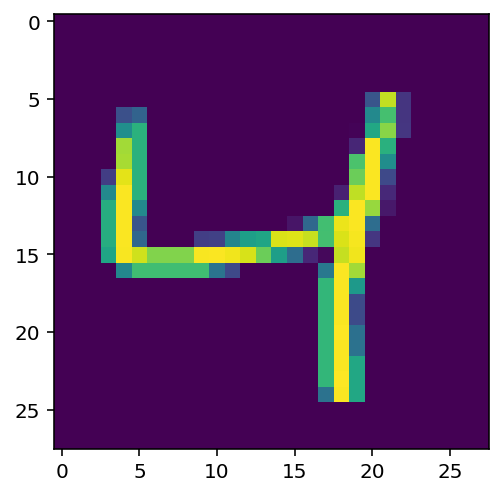

In [9]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [10]:
inputs = sagemaker.Session().upload_data(path="mnist", bucket=bucket, key_prefix=prefix)
print("input spec: {}".format(inputs))

input spec: s3://sagemaker-experiments-us-west-2-000000000000/mnist


Now lets track the parameters from the data pre-processing step.

In [11]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters(
        {
            "normalization_mean": 0.1307,
            "normalization_std": 0.3081,
        }
    )
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

### Step 1 - Set up the Experiment

Create an experiment to track all the model training iterations. Experiments are a great way to organize your data science work. You can create experiments to organize all your model development work for : [1] a business use case you are addressing (e.g. create experiment named “customer churn prediction”), or [2] a data science team that owns the experiment (e.g. create experiment named “marketing analytics experiment”), or [3] a specific data science and ML project. Think of it as a “folder” for organizing your “files”.

### Create an Experiment

In [12]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}",
    description="Classification of mnist hand-written digits",
    sagemaker_boto_client=sm,
)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f685a655278>,experiment_name='mnist-hand-written-digits-classification-1649337260',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-west-2:000000000000:experiment/mnist-hand-written-digits-classification-1649337260',response_metadata={'RequestId': '31177a86-d40b-42c4-849a-db8efaa33f40', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '31177a86-d40b-42c4-849a-db8efaa33f40', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Thu, 07 Apr 2022 13:14:19 GMT'}, 'RetryAttempts': 0})


### Step 2 - Track Experiment
### Now create a Trial for each training run to track the it's inputs, parameters, and metrics.
While training the CNN model on SageMaker, we will experiment with several values for the number of hidden channel in the model. We will create a Trial to track each training job run. We will also create a TrialComponent from the tracker we created before, and add to the Trial. This will enrich the Trial with the parameters we captured from the data pre-processing stage.

Note the execution of the following code takes a while.

In [13]:
from sagemaker.pytorch import PyTorch, PyTorchModel

In [14]:
hidden_channel_trial_name_map = {}

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [15]:
preprocessing_trial_component = tracker.trial_component

In [16]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name,
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name

    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)

    # all input configurations, parameters, and metrics specified in estimator
    # definition are automatically tracked
    estimator = PyTorch(
        py_version="py3",
        entry_point="./mnist.py",
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version="1.1.0",
        instance_count=1,
        instance_type="ml.c4.xlarge",
        hyperparameters={
            "epochs": 2,
            "backend": "gloo",
            "hidden_channels": num_hidden_channel,
            "dropout": 0.2,
            "kernel_size": 5,
            "optimizer": "sgd",
        },
        metric_definitions=[
            {"Name": "train:loss", "Regex": "Train Loss: (.*?);"},
            {"Name": "test:loss", "Regex": "Test Average loss: (.*?),"},
            {"Name": "test:accuracy", "Regex": "Test Accuracy: (.*?)%;"},
        ],
        enable_sagemaker_metrics=True,
    )

    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))

    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={"training": inputs},
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )

    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1649337273


2022-04-07 13:14:34 Starting - Starting the training job.

.

.


2022-04-07 13:14:57 Starting - Preparing the instances for trainingProfilerReport-1649337274: InProgress
.

.

.

.

.

.


2022-04-07 13:16:04 Downloading - Downloading input data.

.

.


2022-04-07 13:16:35 Training - Downloading the training image.

.

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-07 13:16:48,474 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-04-07 13:16:48,476 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:16:48,488 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-07 13:16:48,489 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-07 13:16:48,841 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-04-07 13:16:48,841 sagemaker-containers INFO     Generating setup.cfg
2022-04-07 13:16:48,842 sagemaker-containers INFO     Generating MANIFEST.in
2022-04-07 13:16:48,842 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn


2022-04-07 13:16:58 Training - Training image download completed. Training in progress.Distributed training - False
Number of gpus available - 0
Get train data loader
Get test data loader
Processes 60000/60000 (100%) of train data
Processes 10000/10000 (100%) of test data
Train Epoch: 1 [6400/60000 (11%)], Train Loss: 1.617049;
Train Epoch: 1 [12800/60000 (21%)], Train Loss: 0.941270;
Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.843992;


Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.432059;
Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.464780;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.322854;
Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.351526;


Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.389307;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.375780;
Test Average loss: 0.1852, Test Accuracy: 95%;
Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.275706;


Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.292543;
Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.244455;
Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.283167;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.279576;
Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.341436;


Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.414407;
Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.193495;


Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.157259;
Test Average loss: 0.1158, Test Accuracy: 97%;
Saving the model.
2022-04-07 13:17:44,715 sagemaker-containers INFO     Reporting training SUCCESS



2022-04-07 13:18:01 Uploading - Uploading generated training model
2022-04-07 13:18:01 Completed - Training job completed


Training seconds: 117
Billable seconds: 117


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1649337501


2022-04-07 13:18:22 Starting - Starting the training job.

.

.


2022-04-07 13:18:46 Starting - Preparing the instances for trainingProfilerReport-1649337502: InProgress
.

.

.

.

.

.

.

.

.


2022-04-07 13:20:07 Downloading - Downloading input data.

.

.


2022-04-07 13:20:52 Training - Training image download completed. Training in progress..

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-07 13:20:56,184 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-04-07 13:20:56,186 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:20:56,198 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-07 13:20:56,200 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-07 13:20:56,649 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-04-07 13:20:56,649 sagemaker-containers INFO     Generating setup.cfg
2022-04-07 13:20:56,649 sagemaker-containers INFO     Generating MANIFEST.in
2022-04-07 13:20:56,650 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn

  Running setup.py bdist_wheel for mnist: finished with status 'done'
  Stored in directory: /tmp/pip-ephem-wheel-cache-ttlfjh1x/wheels/35/24/16/37574d11bf9bde50616c67372a334f94fa8356bc7164af8ca3
Successfully built mnist
You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2022-04-07 13:20:59,125 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:20:59,141 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_pytorch_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "backend": "gloo",
        "dropout": 0.2,
        "epochs": 2,
        "hidden_channels": 5,
        "kernel_size": 5,
        "optimizer": "sg

Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.611539;
Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.648925;
Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.571486;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.791933;


Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.438099;
Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.549112;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.480673;
Test Average loss: 0.1914, Test Accuracy: 94%;


Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.297167;
Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.364907;
Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.268553;


Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.272427;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.382764;


Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.482188;
Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.203590;
Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.445356;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.197844;


Test Average loss: 0.1157, Test Accuracy: 96%;
Saving the model.
2022-04-07 13:21:55,569 sagemaker-containers INFO     Reporting training SUCCESS



2022-04-07 13:22:27 Uploading - Uploading generated training model
2022-04-07 13:22:27 Completed - Training job completed


Training seconds: 138
Billable seconds: 138


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1649337762


2022-04-07 13:22:42 Starting - Starting the training job.

.

.


2022-04-07 13:23:09 Starting - Preparing the instances for trainingProfilerReport-1649337762: InProgress
.

.

.

.

.

.

.

.

.


2022-04-07 13:24:37 Downloading - Downloading input data.

.

.


2022-04-07 13:25:10 Training - Training image download completed. Training in progress..

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-07 13:25:13,637 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-04-07 13:25:13,639 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:25:13,653 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-07 13:25:13,655 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-07 13:25:14,071 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-04-07 13:25:14,071 sagemaker-containers INFO     Generating setup.cfg
2022-04-07 13:25:14,071 sagemaker-containers INFO     Generating MANIFEST.in
2022-04-07 13:25:14,071 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn

Train Epoch: 1 [6400/60000 (11%)], Train Loss: 1.695285;
Train Epoch: 1 [12800/60000 (21%)], Train Loss: 0.928432;
Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.702160;
Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.442871;


Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.413667;
Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.501132;


Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.383585;
Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.328490;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.396089;
Test Average loss: 0.1679, Test Accuracy: 95%;


Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.603119;
Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.229334;
Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.281790;
Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.376957;


Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.412861;
Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.200810;


Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.233049;
Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.319483;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.210030;
Test Average loss: 0.1060, Test Accuracy: 97%;
Saving the model.
2022-04-07 13:26:22,304 sagemaker-containers INFO     Reporting training SUCCESS



2022-04-07 13:26:41 Uploading - Uploading generated training model
2022-04-07 13:26:41 Completed - Training job completed


Training seconds: 133
Billable seconds: 133


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1649338019


2022-04-07 13:27:01 Starting - Starting the training job.

.

.

ProfilerReport-1649338020: InProgress
.

.

.


2022-04-07 13:27:51 Starting - Preparing the instances for training.

.

.

.

.

.


2022-04-07 13:28:52 Downloading - Downloading input data.

.

.

.

.

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-07 13:29:41,625 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-04-07 13:29:41,629 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:29:41,640 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-07 13:29:41,641 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-07 13:29:42,034 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-04-07 13:29:42,034 sagemaker-containers INFO     Generating setup.cfg
2022-04-07 13:29:42,034 sagemaker-containers INFO     Generating MANIFEST.in
2022-04-07 13:29:42,035 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn


2022-04-07 13:29:52 Training - Training image download completed. Training in progress.Train Epoch: 1 [12800/60000 (21%)], Train Loss: 1.013725;
Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.799500;


Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.595724;
Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.411506;


Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.176120;
Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.317887;


Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.203233;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.264020;
Test Average loss: 0.1407, Test Accuracy: 96%;
Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.384039;


Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.200869;
Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.399078;


Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.451251;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.263621;


Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.151691;
Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.375438;
Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.332934;
Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.227200;


Test Average loss: 0.0965, Test Accuracy: 97%;
Saving the model.
2022-04-07 13:31:06,108 sagemaker-containers INFO     Reporting training SUCCESS



2022-04-07 13:31:32 Uploading - Uploading generated training model
2022-04-07 13:31:32 Completed - Training job completed
ProfilerReport-1649338020: NoIssuesFound


Training seconds: 150
Billable seconds: 150


INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


INFO:sagemaker:Creating training-job with name: cnn-training-job-1649338307


2022-04-07 13:31:48 Starting - Starting the training job.

.

.


2022-04-07 13:32:13 Starting - Preparing the instances for trainingProfilerReport-1649338307: InProgress
.

.

.

.

.

.

.

.

.


2022-04-07 13:33:31 Downloading - Downloading input data.

.

.


2022-04-07 13:34:11 Training - Training image download completed. Training in progress.

bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-04-07 13:34:12,686 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2022-04-07 13:34:12,690 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:34:12,701 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-04-07 13:34:12,703 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-04-07 13:34:13,078 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2022-04-07 13:34:13,078 sagemaker-containers INFO     Generating setup.cfg
2022-04-07 13:34:13,078 sagemaker-containers INFO     Generating MANIFEST.in
2022-04-07 13:34:13,078 sagemaker-containers INFO     Installing module with the following command:
/usr/bin/python -m pip install . 
Processing /opt/ml/code
  Running setup.py bdist_wheel for mn

You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
2022-04-07 13:34:15,715 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-04-07 13:34:15,730 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_pytorch_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperparameters": {
        "backend": "gloo",
        "dropout": 0.2,
        "epochs": 2,
        "hidden_channels": 32,
        "kernel_size": 5,
        "optimizer": "sgd"
    },
    "input_config_dir": "/opt/ml/input/config",
    "input_data_config": {
        "training": {
            "TrainingInputMode": "File",
            "S3DistributionType": "FullyReplicated",
            "Record

Train Epoch: 1 [19200/60000 (32%)], Train Loss: 0.747446;
Train Epoch: 1 [25600/60000 (43%)], Train Loss: 0.516501;


Train Epoch: 1 [32000/60000 (53%)], Train Loss: 0.465859;


Train Epoch: 1 [38400/60000 (64%)], Train Loss: 0.380938;
Train Epoch: 1 [44800/60000 (75%)], Train Loss: 0.451455;
Train Epoch: 1 [51200/60000 (85%)], Train Loss: 0.202041;
Train Epoch: 1 [57600/60000 (96%)], Train Loss: 0.379481;


Test Average loss: 0.1531, Test Accuracy: 95%;


Train Epoch: 2 [6400/60000 (11%)], Train Loss: 0.183234;
Train Epoch: 2 [12800/60000 (21%)], Train Loss: 0.523121;


Train Epoch: 2 [19200/60000 (32%)], Train Loss: 0.199367;
Train Epoch: 2 [25600/60000 (43%)], Train Loss: 0.200822;
Train Epoch: 2 [32000/60000 (53%)], Train Loss: 0.377310;
Train Epoch: 2 [38400/60000 (64%)], Train Loss: 0.227790;


Train Epoch: 2 [44800/60000 (75%)], Train Loss: 0.642007;
Train Epoch: 2 [51200/60000 (85%)], Train Loss: 0.365126;


Train Epoch: 2 [57600/60000 (96%)], Train Loss: 0.101494;


Test Average loss: 0.1012, Test Accuracy: 97%;
Saving the model.
2022-04-07 13:35:49,252 sagemaker-containers INFO     Reporting training SUCCESS



2022-04-07 13:36:12 Uploading - Uploading generated training model
2022-04-07 13:36:12 Completed - Training job completed
ProfilerReport-1649338307: NoIssuesFound


Training seconds: 162
Billable seconds: 162


### Compare the model training runs for an experiment

Now we will use the analytics capabilities of Python SDK to query and compare the training runs for identifying the best model produced by our experiment. You can retrieve trial components by using a search expression.

### Some Simple Analyses

In [17]:
search_expression = {
    "Filters": [
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [18]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=["test:accuracy"],
    parameter_names=["hidden_channels", "epochs", "dropout", "optimizer"],
)

In [19]:
trial_component_analytics.dataframe()

TrialComponentName DisplayName  \
0  cnn-training-job-1649338019-aws-training-job    Training   
1  cnn-training-job-1649337273-aws-training-job    Training   
2  cnn-training-job-1649338307-aws-training-job    Training   
3  cnn-training-job-1649337762-aws-training-job    Training   
4  cnn-training-job-1649337501-aws-training-job    Training   

                                           SourceArn  dropout  epochs  \
0  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
1  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
2  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
3  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   
4  arn:aws:sagemaker:us-west-2:000000000000:train...      0.2     2.0   

   hidden_channels optimizer  test:accuracy - Min  test:accuracy - Max  \
0             20.0     "sgd"                 96.0                 97.0   
1              2.0     "sgd"                 95.0                 97.0   
2             32.0     "sgd"                 95.0                 97.0   
3             10.0     "sgd"                 95.0                 97.0   
4              5.0     "sgd"                 94.0                 96.0   

   test:accuracy - Avg  ...  test:accuracy - Last  test:accuracy - Count  \
0                 96.5  ...                  97.0                      2   
1                 96.0  ...                  97.0                      2   
2                 96.0  ...                  97.0                      2   
3                 96.0  ...                  97.0                      2   
4                 95.0  ...                  96.0                      2   

   training - MediaType                                   training - Value  \
0                  None  s3://sagemaker-experiments-us-west-2-521695447...   
1                  None  s3://sagemaker-experiments-us-west-2-521695447...   
2                  None  s3://sagemaker-experiments-us-west-2-521695447...   
3                  None  s3://sagemaker-experiments-us-west-2-521695447...   
4                  None  s3://sagemaker-experiments-us-west-2-521695447...   

  SageMaker.DebugHookOutput - MediaType  \
0                                  None   
1                                  None   
2                                  None   
3                                  None   
4                                  None   

        SageMaker.DebugHookOutput - Value SageMaker.ModelArtifact - MediaType  \
0  s3://sagemaker-us-west-2-000000000000/                                None   
1  s3://sagemaker-us-west-2-000000000000/                                None   
2  s3://sagemaker-us-west-2-000000000000/                                None   
3  s3://sagemaker-us-west-2-000000000000/                                None   
4  s3://sagemaker-us-west-2-000000000000/                                None   

                     SageMaker.ModelArtifact - Value  \
0  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
1  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
2  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
3  s3://sagemaker-us-west-2-000000000000/cnn-trai...   
4  s3://sagemaker-us-west-2-000000000000/cnn-trai...   

                                             Trials  \
0  [cnn-training-job-20-hidden-channels-1649338019]   
1   [cnn-training-job-2-hidden-channels-1649337273]   
2  [cnn-training-job-32-hidden-channels-1649338307]   
3  [cnn-training-job-10-hidden-channels-1649337761]   
4   [cnn-training-job-5-hidden-channels-1649337501]   

                                         Experiments  
0  [mnist-hand-written-digits-classification-1649...  
1  [mnist-hand-written-digits-classification-1649...  
2  [mnist-hand-written-digits-classification-1649...  
3  [mnist-hand-written-digits-classification-1649...  
4  [mnist-hand-written-digits-classification-1649...  

[5 rows x 21 columns]

To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [20]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm),
    search_expression={
        "Filters": [
            {
                "Name": "Parents.TrialName",
                "Operator": "Equals",
                "Value": hidden_channel_trial_name_map[2],
            }
        ]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [21]:
lineage_table.dataframe()

TrialComponentName    DisplayName  \
0         TrialComponent-2022-04-07-131413-jyoi  Preprocessing   
1  cnn-training-job-1649337273-aws-training-job       Training   

   normalization_mean  normalization_std mnist-dataset - MediaType  \
0              0.1307             0.3081                    s3/uri   
1                 NaN                NaN                       NaN   

                               mnist-dataset - Value  \
0  s3://sagemaker-experiments-us-west-2-521695447...   
1                                                NaN   

                                              Trials  \
0  [cnn-training-job-5-hidden-channels-1649337501...   
1    [cnn-training-job-2-hidden-channels-1649337273]   

                                         Experiments  \
0  [mnist-hand-written-digits-classification-1649...   
1  [mnist-hand-written-digits-classification-1649...   

                                           SourceArn  \
0                                                NaN   
1  arn:aws:sagemaker:us-west-2:000000000000:train...   

                                  SageMaker.ImageUri  ...  train:loss - Avg  \
0                                                NaN  ...               NaN   
1  520713654638.dkr.ecr.us-west-2.amazonaws.com/s...  ...          0.456703   

  train:loss - StdDev  train:loss - Last train:loss - Count  \
0                 NaN                NaN                NaN   
1            0.352488           0.157259               18.0   

   training - MediaType                                   training - Value  \
0                   NaN                                                NaN   
1                   NaN  s3://sagemaker-experiments-us-west-2-521695447...   

   SageMaker.DebugHookOutput - MediaType  \
0                                    NaN   
1                                    NaN   

        SageMaker.DebugHookOutput - Value SageMaker.ModelArtifact - MediaType  \
0                                     NaN                                 NaN   
1  s3://sagemaker-us-west-2-000000000000/                                 NaN   

                     SageMaker.ModelArtifact - Value  
0                                                NaN  
1  s3://sagemaker-us-west-2-000000000000/cnn-trai...  

[2 rows x 48 columns]

## Deploy endpoint for the best training-job / trial component

Now we'll take the best (as sorted) and create an endpoint for it.

In [22]:
# Pulling best based on sort in the analytics/dataframe so first is best....
best_trial_component_name = trial_component_analytics.dataframe().iloc[0]["TrialComponentName"]
best_trial_component = TrialComponent.load(best_trial_component_name)

model_data = best_trial_component.output_artifacts["SageMaker.ModelArtifact"].value
env = {
    "hidden_channels": str(int(best_trial_component.parameters["hidden_channels"])),
    "dropout": str(best_trial_component.parameters["dropout"]),
    "kernel_size": str(int(best_trial_component.parameters["kernel_size"])),
}
model = PyTorchModel(
    model_data,
    role,
    "./mnist.py",
    py_version="py3",
    env=env,
    sagemaker_session=sagemaker.Session(sagemaker_client=sm),
    framework_version="1.1.0",
    name=best_trial_component.trial_component_name,
)

predictor = model.deploy(instance_type="ml.m5.xlarge", initial_instance_count=1)

INFO:sagemaker:Creating model with name: cnn-training-job-1649338019-aws-training-job


INFO:sagemaker:Creating endpoint-config with name cnn-training-job-1649338019-aws-trainin-2022-04-07-13-36-50-015


INFO:sagemaker:Creating endpoint with name cnn-training-job-1649338019-aws-trainin-2022-04-07-13-36-50-015


-

-

-

-

!

## Cleanup

Once we're doing don't forget to clean up the endpoint to prevent unnecessary billing.

> Trial components can exist independent of trials and experiments. You might want keep them if you plan on further exploration. If so, comment out tc.delete()

In [23]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: cnn-training-job-1649338019-aws-trainin-2022-04-07-13-36-50-015


INFO:sagemaker:Deleting endpoint with name: cnn-training-job-1649338019-aws-trainin-2022-04-07-13-36-50-015


In [24]:
mnist_experiment.delete_all(action="--force")

## Contact
Submit any questions or issues to https://github.com/aws/sagemaker-experiments/issues or mention @aws/sagemakerexperimentsadmin 